In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from scipy.signal import resample
import random
np.random.seed(42)

import keras

import seaborn as sns

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.grid':True,
         'axes.grid.which':'both'
         }
plt.rcParams.update(params)

# Read Dataset

In [ ]:
df = pd.read_csv("./drive/MyDrive/mitbih_train.csv", header=None)
df2 = pd.read_csv("./drive/MyDrive/mitbih_test.csv", header=None)
# df = pd.concat([df, df2], axis=0)
df = df.reset_index().drop('index', axis='columns')

It is a good idea to look at the distribution of the data before working with it.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,87554.0,0.890360,0.240909,0.0,0.921922,0.991342,1.000000,1.0
1,87554.0,0.758160,0.221813,0.0,0.682486,0.826013,0.910506,1.0
2,87554.0,0.423972,0.227305,0.0,0.250969,0.429472,0.578767,1.0
3,87554.0,0.219104,0.206878,0.0,0.048458,0.166000,0.341727,1.0
4,87554.0,0.201127,0.177058,0.0,0.082329,0.147878,0.258993,1.0
...,...,...,...,...,...,...,...,...
183,87554.0,0.003471,0.036255,0.0,0.000000,0.000000,0.000000,1.0
184,87554.0,0.003221,0.034789,0.0,0.000000,0.000000,0.000000,1.0
185,87554.0,0.002945,0.032865,0.0,0.000000,0.000000,0.000000,1.0
186,87554.0,0.002807,0.031924,0.0,0.000000,0.000000,0.000000,1.0


- All the fields are between  0 and 1.
- The last fields are mostly zeros.
- count is always the same number. We deduce that there are no missing values.
- The last row has a maximum of 4.... A look at the paper tells us that this is the target field. It is categorical with 4 categories:


In [ ]:
label_names = {0 : 'N',
              1: 'S',
              2: 'V',
              3: 'F',
              4 : 'Q'}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


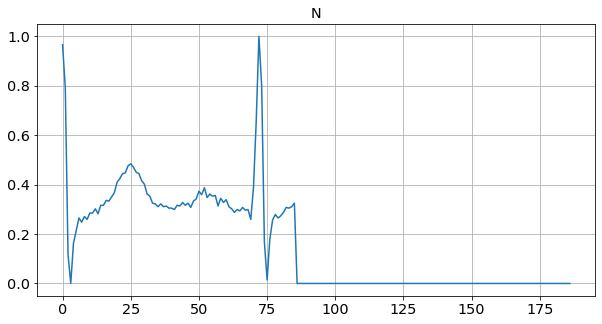

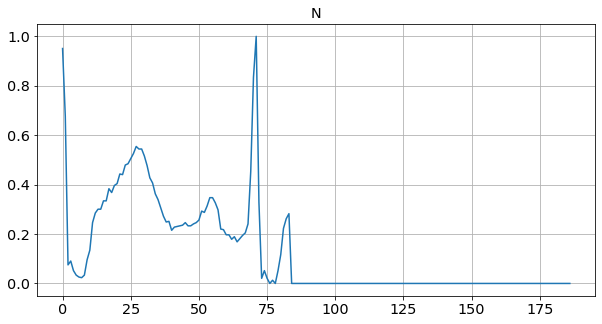

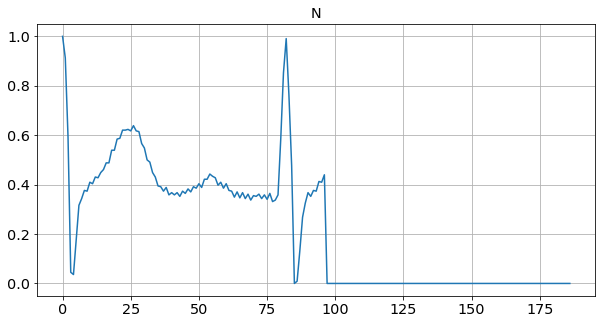

In [ ]:
# show some data
for _ in range(3):
    plt.figure()
    sample = df.sample(1).values.flatten()
    y = label_names[sample[-1]]
    plt.plot(sample[:-1])
    t = plt.title(y)

## Distribution of labels

In [ ]:
label=df[187].value_counts()
label

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

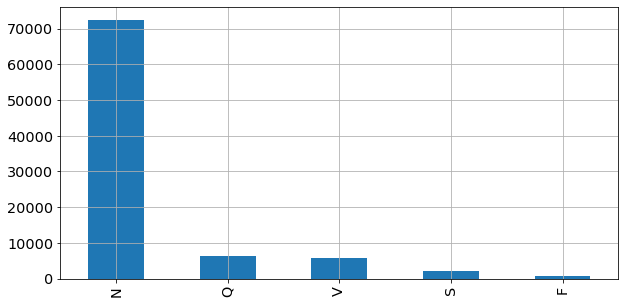

In [ ]:
label.rename(label_names).plot.bar()

In [ ]:
label=df2[187].value_counts()
label

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64

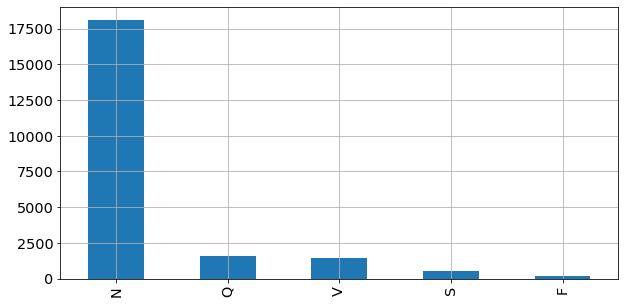

In [ ]:
label.rename(label_names).plot.bar()

In [ ]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor


class Stretch:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return stretch(x)
    
    def __repr__(self):
        return 'Stretch'
    
class Amplify:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return amplify(x)
    
    def __repr__(self):
        return 'Amplify'

class Augment:
    def __init__(self, augmentation_list, return_prints = False):
        self.augmentation_list = augmentation_list
        self.return_prints = return_prints
        
    def __call__(self, x):
        augmentations_performed = ''
        
        for augmentation in self.augmentation_list:
            if np.random.binomial(1, 0.5) == 1:
                x = augmentation(x)
                augmentations_performed += f'{augmentation} '
                
        if not self.return_prints:
            return x
        return x, augmentations_performed



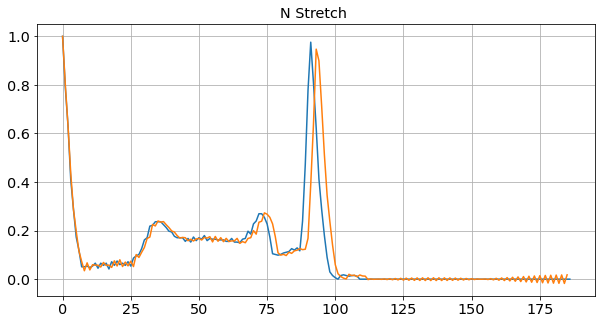

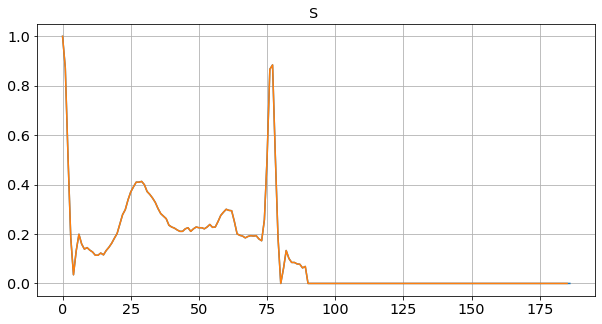

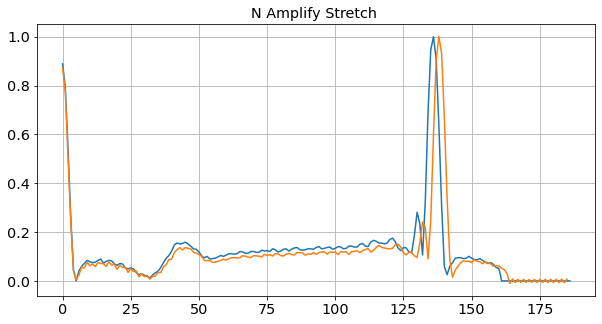

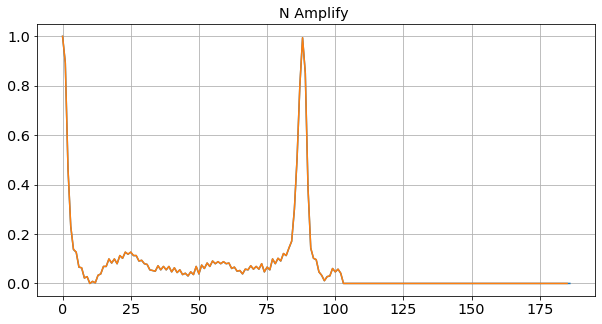

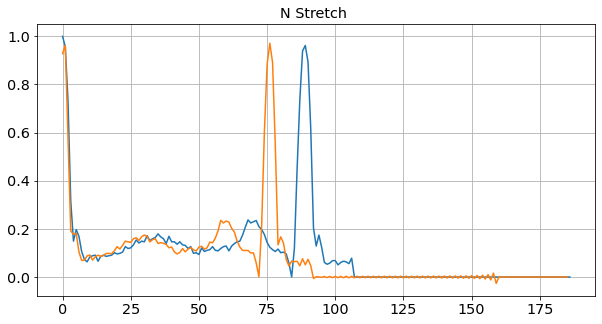

In [ ]:
augment = Augment([Amplify(), Stretch()], True)
for _ in range(5):
    plt.figure()
    sample = df.sample(1).values.flatten()
    y = label_names[sample[-1]]
    plt.plot(sample[:-1])
    
    augmented, augmentations_performed = augment(sample[:-1])
    plt.plot(augmented[:-1])
    
    title = plt.title(y + ' ' + augmentations_performed)

# Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# train_df, test_val_df = train_test_split(df, train_size=0.9, stratify=df.iloc[:,-1])
# val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df.iloc[:,-1])

train_df, val_df = train_test_split(df, train_size=0.8, stratify=df.iloc[:,-1])
test_df = df2
# Make sure the target distribution stays the same...
for temp_df in [train_df, val_df, test_df]:
    print(temp_df.shape[0], temp_df.shape[0] / df.shape[0])
    print(temp_df.iloc[:,-1].value_counts(normalize=True))
    print('\n')

70043 0.7999977156954565
0.0    0.827734
4.0    0.073455
2.0    0.066102
1.0    0.025384
3.0    0.007324
Name: 187, dtype: float64


17511 0.20000228430454348
0.0    0.827708
4.0    0.073440
2.0    0.066130
1.0    0.025413
3.0    0.007310
Name: 187, dtype: float64


21892 0.25003997532951094
0.0    0.827608
4.0    0.073451
2.0    0.066143
1.0    0.025397
3.0    0.007400
Name: 187, dtype: float64




In [ ]:
test_df.shape

(21892, 188)

Note the probabilities! 

### Undersample the over-represented
There is a huge imbalance. The model can easily diminish the loss by ignoring everything other than class 0.
There are several ways to handle this - oversample, undersample, bootstrapping etc.
First, we look at the distribution of samples in the training set:

187
0.0    57977
1.0     1778
2.0     4630
3.0      513
4.0     5145
dtype: int64

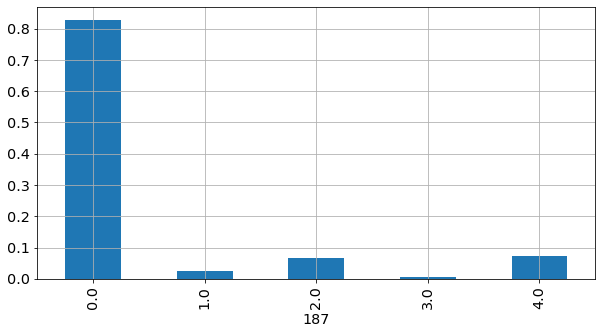

In [ ]:
col = train_df.groupby(187).size()
(col / col.sum()).plot.bar()
col

Next we take the over represented class (N) and sample 5000 samples, randomly. These will be used for training and the rest are ignored.

187
0.0    5000
1.0    1778
2.0    4630
3.0     513
4.0    5145
dtype: int64

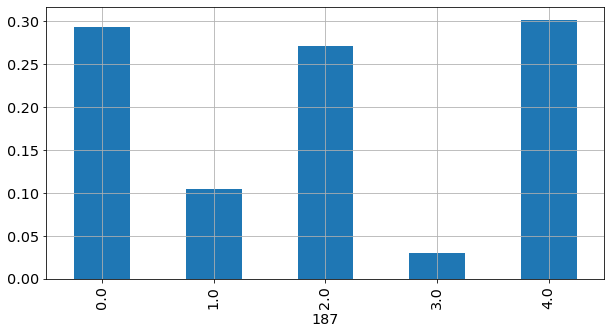

In [ ]:
non_normal_rows = train_df.loc[train_df.iloc[:,-1] != 0]
normal_rows = train_df.loc[train_df.iloc[:,-1] == 0].sample(5000)

train_df = non_normal_rows.append(normal_rows)

col = train_df.groupby(187).size()
(col / col.sum()).plot.bar()
col


![image.png](attachment:image.png)

In [ ]:
from keras.utils.np_utils import to_categorical
x_train = df.iloc[:,:186].values
x_test = df2.iloc[:,:186].values
y_train = df[187]
y_test = df2[187]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras.layers import BatchNormalization
import tensorflow as tf
from keras import optimizers
from keras.layers import MaxPool1D, Convolution1D, Flatten, Dense

In [ ]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras.layers import Flatten
get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
train_df.shape

(17066, 188)

In [ ]:
im_shape = (x_train.shape[1],1)
model = models.Sequential()
model.add(keras.Input(shape=im_shape))
model.add(BatchNormalization())
model.add(Convolution1D(32,(4),activation = 'relu', input_shape = im_shape))
model.add(MaxPool1D(2))
model.add(Convolution1D(64,(4),activation = 'relu', input_shape = im_shape))
model.add(MaxPool1D(2))
model.add(Convolution1D(128,(4),activation = 'relu', input_shape = im_shape))
model.add(Convolution1D(128,(4),activation = 'relu', input_shape = im_shape))
model.add(MaxPool1D(2))
model.add(Convolution1D(128,(4),activation = 'relu', input_shape = im_shape))
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(512, activation = 'sigmoid'))
model.add(Dense(5, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 186, 1)           4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 183, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 91, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 88, 64)            8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 44, 64)           0         
 1D)                                                             
                                                        

In [ ]:
model.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
x_train.shape

(87554, 186)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(x_train, y_train,epochs=10,callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))

Epoch 1/10
2737/2737 [==============================] - 30s 7ms/step - loss: 0.1464 - accuracy: 0.9590 - val_loss: 0.1280 - val_accuracy: 0.9652
Epoch 2/10
2737/2737 [==============================] - 16s 6ms/step - loss: 0.0736 - accuracy: 0.9790 - val_loss: 0.0845 - val_accuracy: 0.9757
Epoch 3/10
2737/2737 [==============================] - 19s 7ms/step - loss: 0.0555 - accuracy: 0.9837 - val_loss: 0.0671 - val_accuracy: 0.9828
Epoch 4/10
2737/2737 [==============================] - 17s 6ms/step - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.0606 - val_accuracy: 0.9834
Epoch 5/10
2737/2737 [==============================] - 16s 6ms/step - loss: 0.0383 - accuracy: 0.9881 - val_loss: 0.0553 - val_accuracy: 0.9842
Epoch 6/10
2737/2737 [==============================] - 17s 6ms/step - loss: 0.0339 - accuracy: 0.9890 - val_loss: 0.0562 - val_accuracy: 0.9855
Epoch 7/10
2737/2737 [==============================] - 16s 6ms/step - loss: 0.0295 - accuracy: 0.9907 - val_loss: 0.0616 - val_ac

In [ ]:
scores = model.evaluate((x_test),y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.51%


In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((x_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Normalized confusion matrix


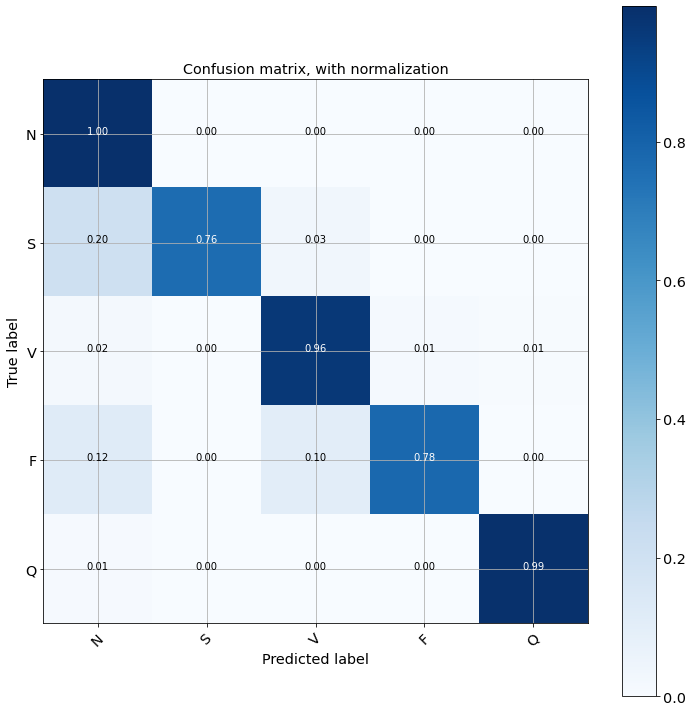

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()


Accuracy: 98.51%


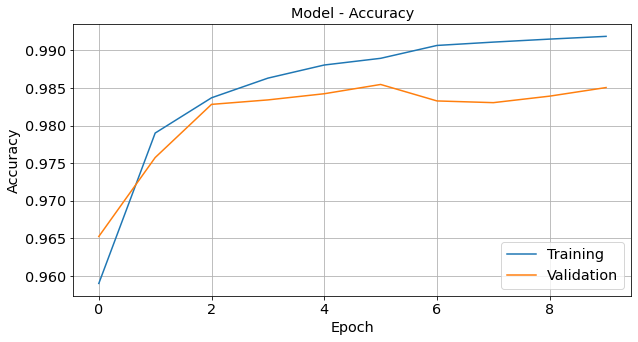

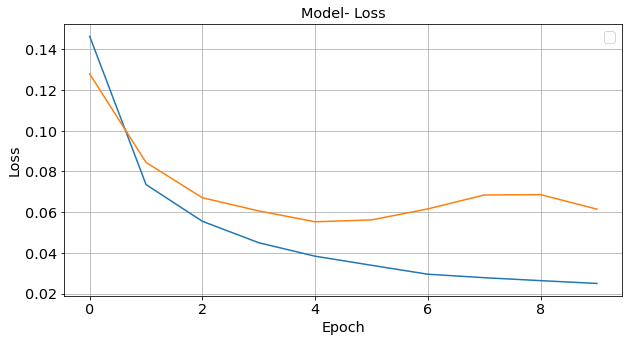

In [ ]:
y_pred=model.predict(x_test)
evaluate_model(history,x_test,y_test,model)

In [ ]:
x_test.shape

(21892, 186)

In [ ]:
ecg = pd.read_csv("./drive/MyDrive/ecg_data.csv", header=None)

In [ ]:
ecg.shape

(895, 1)

In [ ]:
ecg =ecg[:186]

In [ ]:
ecg = ecg.T

In [ ]:
ecg.shape

(1, 186)

In [ ]:
ecg

,0,1,2,3,4,5,6,7,8,9,...,176,177,178,179,180,181,182,183,184,185
0,392,385,385,388,383,369,360,342,327,317,...,180,188,179,191,210,204,222,219,212,217


In [ ]:
y_pred=model.predict(ecg)

In [ ]:
y_pred

array([[7.49e-01, 1.18e-04, 1.38e-01, 3.40e-02, 2.45e-03]], dtype=float32)

In [ ]:
y_pred[0].argmax()

0

In [ ]:
abnormal = pd.read_csv("./drive/MyDrive/ptbdb_abnormal.csv", header=None)

In [ ]:
abnormal

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
ab_label = abnormal[187]

In [ ]:
abnormal.shape

(10506, 188)

In [ ]:
abnormal = abnormal.iloc[:,:186]

In [ ]:
abnormal

,0,1,2,3,4,5,6,7,8,9,...,176,177,178,179,180,181,182,183,184,185
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_pred=model.predict(abnormal)

In [ ]:
pred = []
for i in y_pred[:50]:
  pred.append(i.argmax())

In [ ]:
label = []
for i in label[:50]:
  label.append(i)

In [ ]:
pred

[0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 2]

In [ ]:
ab_label[:50]

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    1.0
48    1.0
49    1.0
Name: 187, dtype: float64

In [ ]:
y_pred

array([[8.17e-01, 1.37e-04, 4.27e-02, 1.84e-04, 3.13e-03],
       [9.88e-01, 3.14e-03, 1.62e-03, 8.36e-04, 1.47e-06],
       [8.68e-01, 6.85e-05, 2.77e-03, 2.28e-04, 3.65e-02],
       ...,
       [9.18e-01, 1.65e-03, 1.29e-02, 7.44e-04, 3.88e-06],
       [9.33e-01, 2.61e-04, 9.58e-05, 7.42e-04, 2.02e-01],
       [9.69e-01, 5.36e-03, 2.44e-04, 3.16e-05, 2.78e-08]], dtype=float32)

In [ ]:
y_pred[0].argmin()

1

In [ ]:
ab_label[3000]

1.0

In [ ]:
np.argmax(y_pred[3])

0

In [ ]:
y_pred.argmax()

12824

In [ ]:
normal = pd.read_csv("./drive/MyDrive/ptbdb_normal.csv", header=None)

In [ ]:
n_label = normal[187]

In [ ]:
normal = normal.iloc[:,:186]

In [ ]:
y_pred=model.predict(normal)

In [ ]:
y_pred[0].argmax()

0

In [ ]:
y_pred

array([[9.96e-01, 2.64e-03, 3.28e-03, 2.13e-04, 1.27e-06],
       [8.72e-01, 4.64e-03, 5.16e-03, 8.25e-04, 5.29e-07],
       [2.12e-02, 1.85e-03, 9.67e-01, 1.26e-02, 1.44e-08],
       ...,
       [8.71e-01, 9.11e-05, 1.76e-02, 5.92e-04, 7.90e-07],
       [9.90e-01, 3.25e-04, 5.40e-04, 9.93e-04, 2.48e-05],
       [5.08e-01, 4.48e-05, 2.58e-02, 1.89e-03, 3.63e-06]], dtype=float32)